# Analysis

## Data Preparation & Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn.model_selection import cross_val_score
from sklearn import grid_search
import seaborn as sns
from sklearn.preprocessing import normalize

/Users/wliao/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/wliao/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Read in data
df = pd.read_csv('creditcard.csv')

In [3]:
# Preview data
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Evaluate for class imbalance
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
# Undersample to counteact class imbalance
from imblearn.under_sampling import RandomUnderSampler
usampler = RandomUnderSampler()

In [6]:
# Assign features and target variables to X and Y respectively
X = df.drop('Class',axis=1)
Y = df['Class']

# Undersample data
X_sm, Y_sm = usampler.fit_sample(X,Y)

# Put features & target variables back into a dataframe
sm_features = pd.DataFrame(data=X_sm,columns=X.columns)
sm_target = pd.DataFrame(data=Y_sm, columns = ['Class'])

# Put data set backtogether
frames = [sm_features, sm_target]
sm_data = pd.concat(frames,axis=1)

# Assign undersampled data back into X and y; normalize parameters 
X = normalize(sm_features)
y = sm_target.values.ravel()

In [7]:
# Verify that classes are now balanaced
sm_data['Class'].value_counts()

1    492
0    492
Name: Class, dtype: int64

In [8]:
# Do a 70/30 test/train split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

## Experimentation with Different Models

In [9]:
#Initialize lists to store model performance
scores = []
model = []
run_time = []

### Naive Bayes

The exceptional performance of this model can probabably be attributed to a couple of things: 1) we're dealing with components, which means low multicollinearity and 2) Naive Bayes assumes independence. The data complements the model's assumptions. Moreover, the model trains very quickly.

In [10]:
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics

# Initialize model
bnb = BernoulliNB()

# Initialize start time
start_time = time.time()

# Fit model
bnb.fit(X_train,y_train)

# Store training duration
t = (time.time() - start_time)

#Print training duration
print("--- %s seconds ---" % t)

# Append training duration to list for later analysis
run_time.append(t)


nb_scores = cross_val_score(bnb,X_test,y_test,cv=5)

nb_score = np.mean(nb_scores)
scores.append(nb_score)
model.append("Naive Bayes")
print("Mean score:", nb_score)

y_pred = bnb.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

--- 0.0044689178466796875 seconds ---
Mean score: 0.901751412429


Predicted,0,1,All
True,,,
0,145,1,146
1,29,121,150
All,174,122,296


The model generalizes well with our test data, achieving an average of 91% accuracy during cross validation. 

### Decision Tree

Decision trees are appropriate for models with discrete outcomes, making it an appropriate model to test for this data. One caveat, however, is that decision trees don't perform well with data with complex variable relationships. The performance of this model performed reasonably well and didn't suffer too much from overfitting, based on this we can make inferences that the data is not overly complex. This model has the added benefit of moderate training time and a high degree of interpretability. 

In [11]:
from sklearn import tree

decision_tree = tree.DecisionTreeClassifier()
parameters = {'criterion':('gini','entropy'),'max_depth':list(range(1,11,1)),'max_features':list(range(1,5,1))}
gs = grid_search.GridSearchCV(decision_tree, parameters,cv= 3,scoring="accuracy")
gs.fit(X_train,y_train)

decision_tree = tree.DecisionTreeClassifier(**gs.best_params_)

start_time = time.time()
decision_tree.fit(X_train,y_train)
t = (time.time() - start_time)
print("--- %s seconds ---" % t)
run_time.append(t)


decision_tree_scores = cross_val_score(decision_tree, X_test, y_test, cv=5)


decision_tree_score = np.mean(decision_tree_scores)
scores.append(decision_tree_score)
model.append("Decision Tree")
print("Mean score:", decision_tree_score)
print("Optimal parameters:", gs.best_params_)

y_pred = decision_tree.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

--- 0.0018429756164550781 seconds ---
Mean score: 0.857796610169
Optimal parameters: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 4}


Predicted,0,1,All
True,,,
0,135,11,146
1,24,126,150
All,159,137,296


Unfortunately the model's performance is inferior to Naive Bayes -- let's explore other models before considering this one. 

### Random Forest

Random forest tests a random subset of features for each of the trees the model generates, as a result it can address/expose overfitting that you're prone to getting in decision trees. The random forest model run below does offer superior performance relative to the decision tree, which suggests that there was some marginal overfitting in the previous model. A trade-off, however, is the loss of interpretability and longer training duration. 

In [12]:
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()

parameters = {'n_estimators':list(range(1,100,10)),'max_depth':list(range(1,10,1)),'max_features':list(range(1,5,1))}
gs = grid_search.GridSearchCV(rfc, parameters,cv= 3,scoring="accuracy")
gs.fit(X_train,y_train)

rfc = ensemble.RandomForestClassifier(**gs.best_params_)

start_time = time.time()
rfc.fit(X_train,y_train)
t = (time.time() - start_time)
print("--- %s seconds ---" % t)
run_time.append(t)


rfc_scores = cross_val_score(rfc,X_test,y_test,cv=5)


rfc_score = np.mean(rfc_scores)
scores.append(rfc_score)
model.append("Random Forest")
print("Mean score:", rfc_score)
print("Optimal parameters:", gs.best_params_)

y_pred = rfc.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

--- 0.05117511749267578 seconds ---
Mean score: 0.925480225989
Optimal parameters: {'max_depth': 5, 'max_features': 4, 'n_estimators': 31}


Predicted,0,1,All
True,,,
0,146,0,146
1,23,127,150
All,169,127,296


The random forest model performs similarly to Naive Bayes. The Naive Bayes classifier is still superior given its faster training time and comparable performance. 

### KNN

KNN is appropriate for binary classification problems and have the added benefit of dealing with both non-linear and linear data. Some downsides, however, include the model's succeptability to bad features and outliers (noise). The model's perofrmance suggests that the  original data didn't suffer too much from these two areas of succeptability, however it would have been interesting to evaluate the original data to see if any additional wrangling could be done to improve the performance of our KNN classifier. 

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

parameters = {'n_neighbors':list(range(1,50,1)),'weights':('uniform','distance'),'algorithm':('auto','ball_tree','kd_tree','brute')}
gs = grid_search.GridSearchCV(knn, parameters,cv= 3,scoring="accuracy")
gs.fit(X_train,y_train)

knn = KNeighborsClassifier(**gs.best_params_)

start_time = time.time()
knn.fit(X_train, y_train)
t = (time.time() - start_time)
print("--- %s seconds ---" % t)
run_time.append(t)


knn_scores = cross_val_score(knn, X_test, y_test, cv=5)

knn_score = np.mean(knn_scores)
scores.append(knn_score)
model.append("KNN")
print("Mean score:", knn_score)
print("Optimal parameters:", gs.best_params_)

y_pred = knn.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

--- 0.0006380081176757812 seconds ---
Mean score: 0.85802259887
Optimal parameters: {'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}


Predicted,0,1,All
True,,,
0,131,15,146
1,18,132,150
All,149,147,296


The KNN model remains inferior to our Naive Bayes and Random Forest Classifiers, however it's still a contender alongside Decision Trees as they both strike a balance between performance and interpretability. 

### Logistic Regression

Logistic regression trains to the data quite quickly, let's see how the model performs. 

In [60]:
X_log = sm_data.drop('Class',1)
y_log = sm_data['Class']

In [61]:
X_log = X_log.iloc[:,0:20]

In [86]:
X_lr_train = X_train[0:,1:20]
X_lr_test = X_test[0:,1:20]

In [87]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

start_time=time.time()
lr.fit(X_lr_train,y_train)
t = (time.time() - start_time)
print("--- %s seconds ---" % t)
run_time.append(t)

lr_scores = cross_val_score(lr,X_lr_test,y_test,cv=5)

lr_score = np.mean(lr_scores)
scores.append(lr_score)
model.append("Logistic Regression")
print(lr_score)

y_pred = lr.predict(X_lr_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

--- 0.0025298595428466797 seconds ---
0.506779661017


Predicted,0,All
True,,
0,146,146
1,150,150
All,296,296


### SVM

In [15]:
from sklearn.svm import SVC

svc = SVC(C=1000000)

start_time=time.time()
svc.fit(X_train,y_train)
t = (time.time() - start_time)
print("--- %s seconds ---" % t)
run_time.append(t)


svc_scores = cross_val_score(svc,X_test,y_test,cv=5)


svc_score = np.mean(svc_scores)
scores.append(svc_score)
model.append("SVC")
print(svc_score)

y_pred = svc.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

--- 0.02947402000427246 seconds ---
0.59790960452


Predicted,0,1,All
True,,,
0,139,7,146
1,98,52,150
All,237,59,296


### Boosting

Boosting models in some respects are similar to random forests but have the added sophistication by adding weight to observations that are difficult to classify. With this in mind, it makes sense that this model would offer comparable/slightly better performance compared to the random forest model. Boosting also tends to do well even without feature engineering, which makes this model an excellent candidate given that we only have principla components and not the original data. 

In [16]:
from sklearn import grid_search

gradient_boost = ensemble.GradientBoostingClassifier()
parameters = {'n_estimators':list(range(1,501,50)),'max_depth':list(range(1,11,2)),'loss':('exponential','deviance')}
gs = grid_search.GridSearchCV(gradient_boost, parameters,cv= 3,scoring="accuracy")
gs.fit(X_train,y_train)

clf = ensemble.GradientBoostingClassifier(**gs.best_params_)

start_time = time.time()
clf.fit(X_train, y_train)
t = (time.time() - start_time)
print("--- %s seconds ---" % t)
run_time.append(t)
clf_scores = cross_val_score(clf,X_test,y_test,cv=5)

clf_score = np.mean(clf_scores)
scores.append(clf_score)
model.append("Boosting")
print(clf_score)

y_pred = clf.predict(X_test)
pd.crosstab(y_test,y_pred,rownames=['True'],colnames=['Predicted'],margins=True)

--- 0.09285092353820801 seconds ---
0.949209039548


Predicted,0,1,All
True,,,
0,130,16,146
1,18,132,150
All,148,148,296


## Evaluation

Overall, in terms of training duration and overall performance, Naive Bayes is the mode of choice. 

One caveat to point out with the Naive Bayes model is that it's prone to making Type II errors, which means that there will be instances where the model classifies an account as nonfraudulent when in actuality fraud is being committed. Another option is to utilize Boosting. At the expense of a longer training time, you get a model that appears to be slightly less biased towards Type II errors. 

Both of these models, however, ultimately lack in interpretability. If interpretability is essential for the credit card company to utilize the model, then the Decision Tree model performs slightly worse but is much easier to explain. 

In [17]:
results = pd.DataFrame()
results['scores'] = scores
results['model'] = model
results['run_time'] = run_time

In [18]:
results = results.sort_values(by=['scores'])

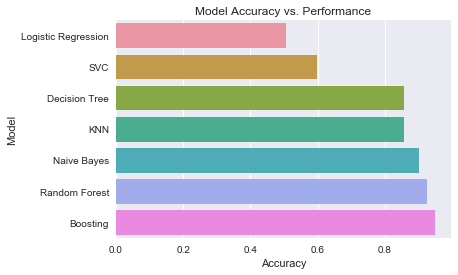

In [19]:
sns.barplot(x=results['scores'],y=results['model'])
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.title("Model Accuracy vs. Performance")

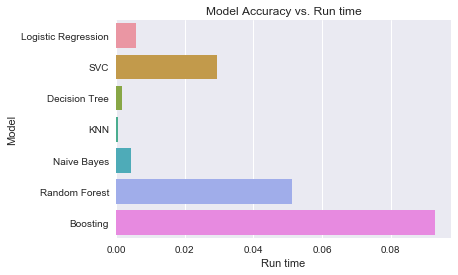

In [20]:
sns.barplot(x=results['run_time'],y=results['model'])
plt.xlabel("Run time")
plt.ylabel("Model")
plt.title("Model Accuracy vs. Run time")